In [4]:
# !pip uninstall normalizer -y
!pip install normalizer


# !pip install normalizer

!pip install git+https://github.com/csebuetnlp/normalizer
!pip install --upgrade transformers
!pip install torch transformers datasets pandas scikit-learn


  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-5rqgn4nr
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-5rqgn4nr
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done


# Implementation


Using: cuda
Using BanglaBERT normalizer
Data: (6000, 4), Labels: {1: 3000, 0: 3000}


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/4800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.429100,0.465042,0.795833,0.795730,0.796434,0.795833
2,0.360300,0.434066,0.795833,0.794852,0.801605,0.795833
3,0.200300,0.474957,0.815833,0.815726,0.816573,0.815833
4,0.308900,0.741968,0.800000,0.799015,0.805998,0.800000
5,0.249900,1.332709,0.824167,0.824167,0.824168,0.824167
6,0.306200,2.300175,0.819167,0.818889,0.821137,0.819167
7,0.374100,2.817101,0.821667,0.821659,0.821724,0.821667
8,0.000100,2.851758,0.824167,0.823999,0.825404,0.824167
9,0.201000,2.862841,0.830000,0.829704,0.832308,0.830000
10,0.097600,2.872647,0.829167,0.828986,0.830563,0.829167


Training complete!



Results: Acc=0.830, F1=0.830, AUC=0.868


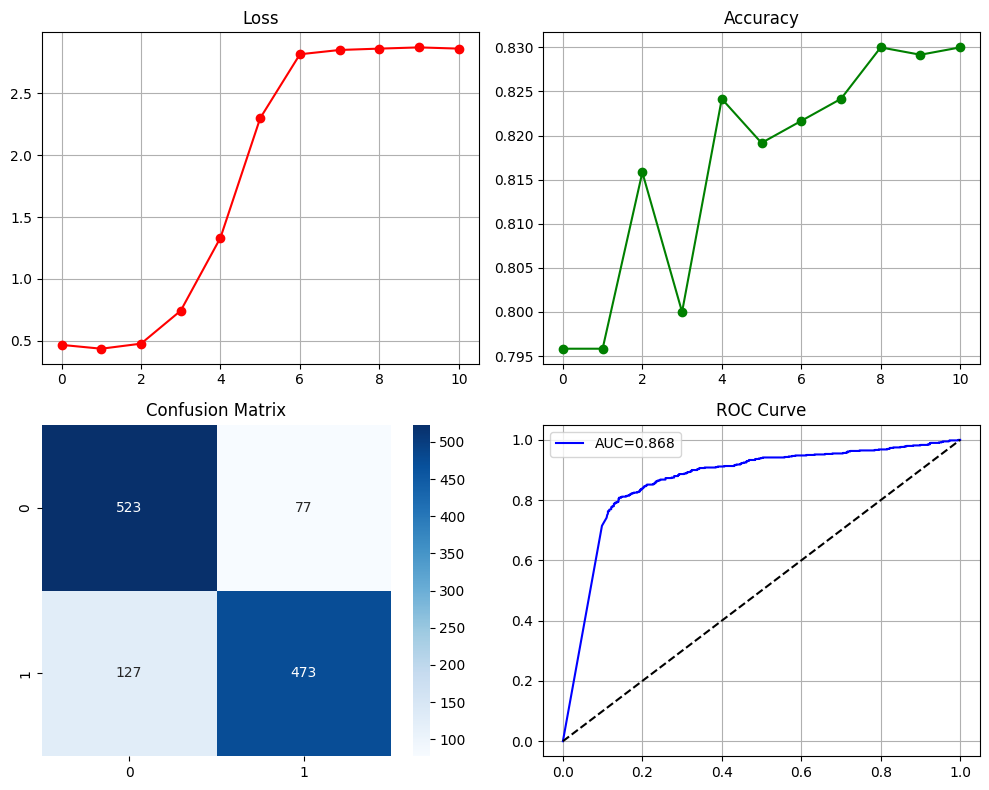

Model saved!
'আমি তোমাকে ভালোবাসি।' -> Non-Hate (1.000)
'তুমি একজন খারাপ মানুষ।' -> Hate (1.000)

🎉 Done! Use predict('text') for inference


In [22]:
# BanglaBERT Hate Speech Detection - Ultra Compact
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from datasets import Dataset
import torch
from collections import defaultdict
import warnings; warnings.filterwarnings('ignore')

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Load data
def load_data():
    for path in ['/kaggle/input/final-hate-speech/combined_final_hate_speech.csv', './combined_final_hate_speech.csv', 'combined_final_hate_speech.csv']:
        try: return pd.read_csv(path)
        except: continue
    raise FileNotFoundError("Dataset not found")

# Normalizer
try:
    from normalizer import normalize
    print("Using BanglaBERT normalizer")
except ImportError:
    print("Warning: Install normalizer with: pip install git+https://github.com/csebuetnlp/normalizer")
    normalize = lambda x: str(x).strip()

# Process data
df = load_data().dropna(subset=['Comment', 'Hate'])
df['text'] = df['Comment'].apply(lambda x: normalize(str(x)))
df['label'] = df['Hate'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
df = df.dropna(subset=['label']).astype({'label': int})
print(f"Data: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")

# Split & tokenize
train_df, eval_df = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42, stratify=df['label'])
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")
model = AutoModelForSequenceClassification.from_pretrained("csebuetnlp/banglabert", num_labels=2).to(device)

def tokenize(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
eval_dataset = Dataset.from_pandas(eval_df).map(tokenize, batched=True)
for ds in [train_dataset, eval_dataset]:
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Trainer
class QuickTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
    def log(self, logs, start_time=None):
        super().log(logs)
        for k, v in logs.items(): self.history[k].append(v)

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': accuracy_score(labels, preds), 'f1': f1, 'precision': p, 'recall': r}

# Train
trainer = QuickTrainer(
    model=model,
    args=TrainingArguments(
        
        output_dir='./results', 
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01, 
        logging_steps=10, 
        report_to="none",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        fp16=torch.cuda.is_available(), 
        dataloader_num_workers=0
    ),
    train_dataset=train_dataset, eval_dataset=eval_dataset, compute_metrics=compute_metrics,
)

print("Training...")
trainer.train()
print("Training complete!")

# Evaluate
preds = trainer.predict(eval_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids
y_prob = torch.softmax(torch.tensor(preds.predictions), dim=1)[:, 1].numpy()

results = trainer.evaluate()
auc = roc_auc_score(y_true, y_prob)
print(f"\nResults: Acc={results['eval_accuracy']:.3f}, F1={results['eval_f1']:.3f}, AUC={auc:.3f}")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
if 'eval_loss' in trainer.history:
    axes[0,0].plot(trainer.history['eval_loss'], 'r-o'); axes[0,0].set_title('Loss'); axes[0,0].grid()
if 'eval_accuracy' in trainer.history:
    axes[0,1].plot(trainer.history['eval_accuracy'], 'g-o'); axes[0,1].set_title('Accuracy'); axes[0,1].grid()
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues'); axes[1,0].set_title('Confusion Matrix')
fpr, tpr, _ = roc_curve(y_true, y_prob)
axes[1,1].plot(fpr, tpr, 'b-', label=f'AUC={auc:.3f}')
axes[1,1].plot([0,1], [0,1], 'k--'); axes[1,1].set_title('ROC Curve'); axes[1,1].legend(); axes[1,1].grid()
plt.tight_layout(); plt.savefig('results.png', dpi=300, bbox_inches='tight'); plt.show()

# Save & predict
model.save_pretrained('./model'); tokenizer.save_pretrained('./model')
print("Model saved!")

def predict(text):
    inputs = tokenizer(normalize(text), return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    pred = torch.argmax(probs).item()
    return {'text': text, 'prediction': 'Hate' if pred == 1 else 'Non-Hate', 'confidence': probs.max().item()}

# Test
for text in ["আমি তোমাকে ভালোবাসি।", "তুমি একজন খারাপ মানুষ।"]:
    result = predict(text)
    print(f"'{text}' -> {result['prediction']} ({result['confidence']:.3f})")



# Hugging Face push (optional)
def push_to_hf(username, model_name="banglabert-hate-speech"):
    try:
        from huggingface_hub import login
        login()  # You'll need to enter your token
        repo_id = f"{username}/{model_name}"
        model.push_to_hub(repo_id)
        tokenizer.push_to_hub(repo_id)
        print(f"Model pushed to: https://huggingface.co/{repo_id}")
    except Exception as e:
        print(f"Push failed: {e}")

# Uncomment to push: push_to_hf("your_username")

print("\n🎉 Done! Use predict('text') for inference")

In [1]:
print("hey")

hey


# Quick inference 

In [23]:
# Quick inference function

def predict(text):
    # Tokenize and normalize the input text
    inputs = tokenizer(normalize(text), return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Make prediction using the model
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    
    # Get the predicted class and probabilities
    pred = torch.argmax(probs).item()
    
    return {
        'text': text,
        'prediction': 'Hate' if pred == 1 else 'Non-Hate',
        'confidence': probs.max().item(),
        'hate_prob': probs[1].item()
    }

# Input text from the user
name_input = input("Enter text or name for classification: ")

# Predict and show the result
result = predict(name_input)
print(f"\n'{result['text']}' -> {result['prediction']} (Confidence: {result['confidence']:.3f})")

Enter text or name for classification:  gw



'gw' -> Hate (Confidence: 1.000)


# Augemnted version  for better Accuracy 


2025-07-09 14:28:06.929656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752071287.127491      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752071287.182402      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using: cuda
Using BanglaBERT normalizer
Data: (379, 4), Labels: {0: 194, 1: 185}
After augmentation: (379, 4), Labels: {0: 194, 1: 185}


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/303 [00:00<?, ? examples/s]

Map:   0%|          | 0/76 [00:00<?, ? examples/s]

Training with enhanced techniques...


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.654700,0.677625,0.736842,0.735742,0.738771,0.736842
2,0.616000,0.575899,0.842105,0.840785,0.858706,0.842105
3,0.437200,0.349033,0.934211,0.934176,0.937061,0.934211
4,0.228400,0.266917,0.907895,0.907847,0.908114,0.907895
5,0.120900,0.270183,0.921053,0.920943,0.925967,0.921053
6,0.065600,0.257842,0.907895,0.907911,0.908241,0.907895
7,0.042000,0.281377,0.921053,0.920943,0.925967,0.921053
8,0.029700,0.304136,0.921053,0.920943,0.925967,0.921053
9,0.021900,0.300157,0.934211,0.934176,0.937061,0.934211
10,0.017600,0.310261,0.934211,0.934176,0.937061,0.934211


Training complete!



Enhanced Results: Acc=0.934, F1=0.934, AUC=0.984


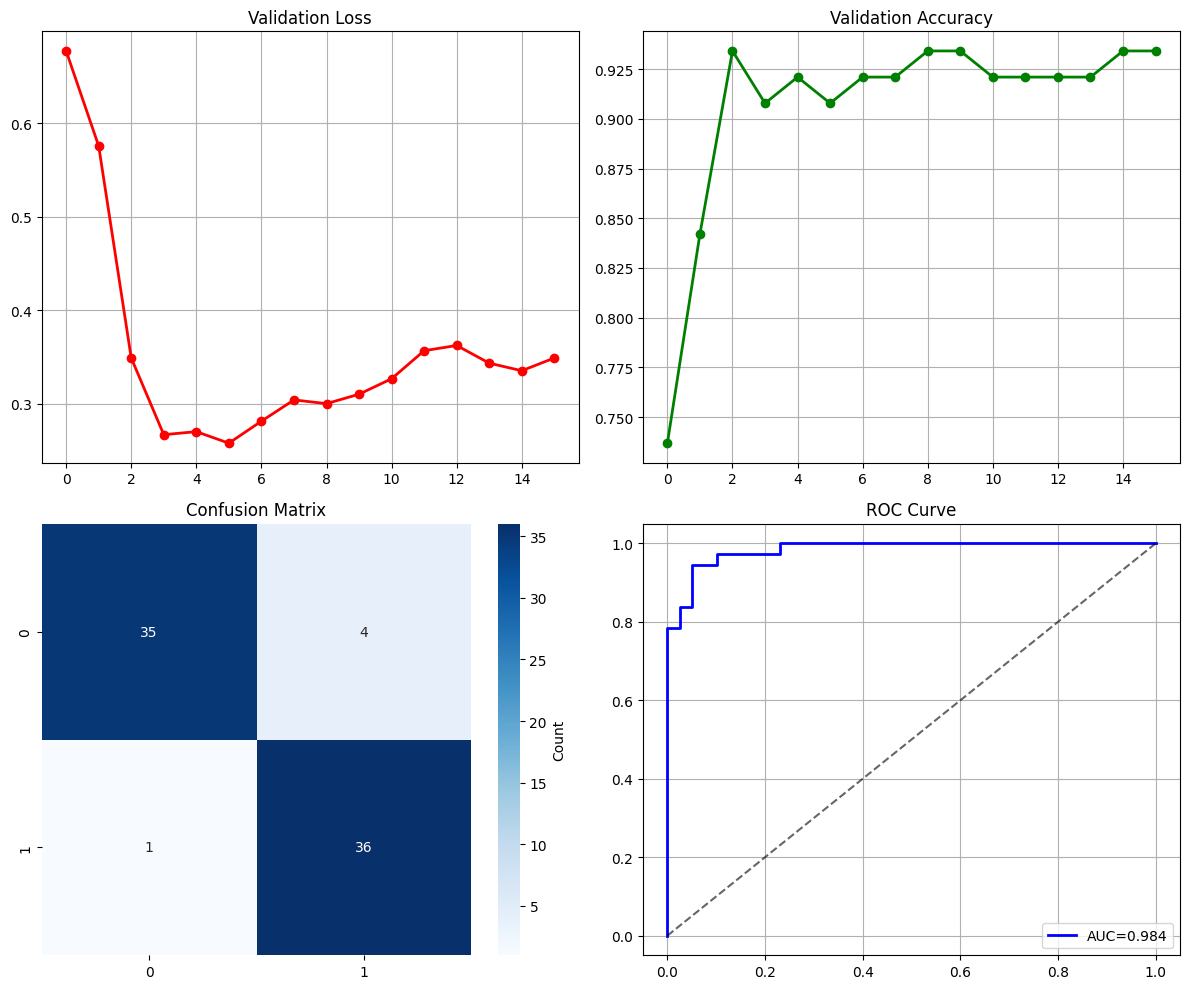

Enhanced model saved!

Enhanced Predictions:
'আমি তোমাকে ভালোবাসি।' -> Non-Hate (Confidence: 0.755)
  Probabilities: {'Non-Hate': 0.7549782991409302, 'Hate': 0.24502162635326385}
'তুমি একজন খারাপ মানুষ।' -> Hate (Confidence: 0.767)
  Probabilities: {'Non-Hate': 0.23322081565856934, 'Hate': 0.7667791843414307}
'এই সরকার সম্পূর্ণ ব্যর্থ।' -> Uncertain (Confidence: 0.637)
  Probabilities: {'Non-Hate': 0.3633562922477722, 'Hate': 0.6366437077522278}
'আমার দেশকে আমি ভালোবাসি।' -> Non-Hate (Confidence: 0.744)
  Probabilities: {'Non-Hate': 0.7443809509277344, 'Hate': 0.2556190490722656}

Training Summary:
Best Accuracy: 0.934
Best F1: 0.934
Final Loss: 0.349

🎉 Enhanced training complete! Use predict('text') for improved inference


In [5]:
# Enhanced BanglaBERT Hate Speech Detection - Ultra Compact with Advanced Techniques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from datasets import Dataset
import torch
import torch.nn as nn
from collections import defaultdict
import warnings; warnings.filterwarnings('ignore')
import re
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow warnings

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

# Load data
def load_data():
    for path in ['/kaggle/input/final-hate-speech/combined_final_hate_speech.csv', './combined_final_hate_speech.csv', 'combined_final_hate_speech.csv']:
        try: return pd.read_csv(path)
        except: continue
    raise FileNotFoundError("Dataset not found")

# Enhanced Normalizer & Preprocessing
try:
    from normalizer import normalize
    print("Using BanglaBERT normalizer")
except ImportError:
    print("Warning: Install normalizer with: pip install git+https://github.com/csebuetnlp/normalizer")
    normalize = lambda x: str(x).strip()

def enhanced_preprocess(text):
    """Enhanced preprocessing with cleaning and normalization"""
    text = str(text).strip()
    text = re.sub(r'[^\u0980-\u09FF\s]', ' ', text)  # Keep only Bangla chars and spaces
    text = re.sub(r'\s+', ' ', text)  # Multiple spaces to single
    text = normalize(text)
    return text.strip()

# Data Augmentation Functions
def synonym_replace(text, n=2):
    """Simple synonym replacement for Bangla (basic examples)"""
    synonyms = {
        'খারাপ': ['বাজে', 'নিকৃষ্ট', 'অসৎ'],
        'ভালো': ['উত্তম', 'চমৎকার', 'সুন্দর'],
        'মানুষ': ['লোক', 'ব্যক্তি', 'জন']
    }
    
    words = text.split()
    new_words = words.copy()
    for i, word in enumerate(words):
        if word in synonyms and random.random() < 0.3:
            new_words[i] = random.choice(synonyms[word])
    return ' '.join(new_words)

def random_insertion(text, n=1):
    """Insert random words from the text itself"""
    words = text.split()
    if len(words) < 2: return text
    for _ in range(n):
        if random.random() < 0.1:
            random_word = random.choice(words)
            random_idx = random.randint(0, len(words))
            words.insert(random_idx, random_word)
    return ' '.join(words)

def random_deletion(text, p=0.05):
    """Randomly delete words"""
    words = text.split()
    if len(words) == 1: return text
    new_words = [word for word in words if random.random() > p]
    return ' '.join(new_words) if new_words else text

def augment_text(text, label):
    """Apply augmentation techniques"""
    if random.random() < 0.3:  # 30% chance to augment
        augmented = text
        if random.random() < 0.4: augmented = synonym_replace(augmented)
        if random.random() < 0.3: augmented = random_insertion(augmented)
        if random.random() < 0.2: augmented = random_deletion(augmented)
        return augmented
    return text

# Process data with enhanced preprocessing
df = load_data().dropna(subset=['Comment', 'Hate'])
df['text'] = df['Comment'].apply(enhanced_preprocess)
df['label'] = df['Hate'].map({'Yes': 1, 'No': 0, 'yes': 1, 'no': 0, 'YES': 1, 'NO': 0})
df = df.dropna(subset=['label']).astype({'label': int})

# Remove duplicates and filter short texts
df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
df = df[df['text'].str.len() > 3]  # Remove very short texts

print(f"Data: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")

# Data Augmentation for minority class balancing
def balance_with_augmentation(df, target_ratio=0.6):
    """Balance dataset using augmentation"""
    hate_df = df[df['label'] == 1]
    non_hate_df = df[df['label'] == 0]
    
    # Augment hate speech samples if minority
    if len(hate_df) < len(non_hate_df):
        needed = int(len(non_hate_df) * target_ratio) - len(hate_df)
        augmented_samples = []
        
        for _ in range(needed):
            sample = hate_df.sample(1).iloc[0]
            augmented_text = augment_text(sample['text'], sample['label'])
            augmented_samples.append({'text': augmented_text, 'label': sample['label']})
        
        aug_df = pd.DataFrame(augmented_samples)
        df = pd.concat([df, aug_df], ignore_index=True)
    
    return df.sample(frac=1, random_state=42).reset_index(drop=True)

df = balance_with_augmentation(df)
print(f"After augmentation: {df.shape}, Labels: {df['label'].value_counts().to_dict()}")

# Split & tokenize with stratification
train_df, eval_df = train_test_split(df[['text', 'label']], test_size=0.2, random_state=42, stratify=df['label'])
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

# Enhanced Model with Dropout
class EnhancedBERTModel(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_rate=0.3):
        super().__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        if labels is not None:
            return outputs
        # Apply additional dropout during inference
        logits = self.dropout(outputs.logits)
        return type(outputs)(logits=logits, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

model = EnhancedBERTModel("csebuetnlp/banglabert").to(device)

def tokenize(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=256)  # Increased max_length

train_dataset = Dataset.from_pandas(train_df).map(tokenize, batched=True)
eval_dataset = Dataset.from_pandas(eval_df).map(tokenize, batched=True)
for ds in [train_dataset, eval_dataset]:
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Enhanced Trainer with Custom Optimizer
class EnhancedTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.history = defaultdict(list)
    
    def create_optimizer(self):
        """Custom optimizer with different learning rates for different layers"""
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in self.model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.args.weight_decay,
                "lr": self.args.learning_rate
            },
            {
                "params": [p for n, p in self.model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": self.args.learning_rate
            }
        ]
        self.optimizer = AdamW(optimizer_grouped_parameters, lr=self.args.learning_rate, eps=1e-8)
        return self.optimizer
    
    def create_scheduler(self, num_training_steps: int, optimizer=None):
        """Custom scheduler with warmup"""
        if optimizer is None:
            optimizer = self.optimizer
        self.lr_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(0.1 * num_training_steps),  # 10% warmup
            num_training_steps=num_training_steps
        )
        return self.lr_scheduler
    
    def log(self, logs, start_time=None):
        super().log(logs)
        for k, v in logs.items(): self.history[k].append(v)

def compute_metrics(eval_pred):
    preds, labels = eval_pred
    preds = np.argmax(preds, axis=1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {'accuracy': accuracy_score(labels, preds), 'f1': f1, 'precision': p, 'recall': r}

# Enhanced Training Arguments with Hyperparameter Tuning
training_args = TrainingArguments(
    output_dir='./results', 
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,  # Slightly higher
    per_device_train_batch_size=16,  # Increased batch size
    per_device_eval_batch_size=32,
    num_train_epochs=15,  # More epochs
    weight_decay=0.01,
    warmup_steps=500,  # Warmup steps
    logging_steps=10,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=0,
    save_total_limit=2,
    gradient_accumulation_steps=2,  # Effective batch size = 16*2 = 32
    adam_epsilon=1e-8,
    max_grad_norm=1.0,  # Gradient clipping
    lr_scheduler_type="linear"
)

# Train with Enhanced Trainer
trainer = EnhancedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

print("Training with enhanced techniques...")
trainer.train()
print("Training complete!")

# Evaluate
preds = trainer.predict(eval_dataset)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids
y_prob = torch.softmax(torch.tensor(preds.predictions), dim=1)[:, 1].numpy()

results = trainer.evaluate()
auc = roc_auc_score(y_true, y_prob)
print(f"\nEnhanced Results: Acc={results['eval_accuracy']:.3f}, F1={results['eval_f1']:.3f}, AUC={auc:.3f}")

# Enhanced Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
if 'eval_loss' in trainer.history:
    axes[0,0].plot(trainer.history['eval_loss'], 'r-o', linewidth=2); axes[0,0].set_title('Validation Loss', fontsize=12); axes[0,0].grid()
if 'eval_accuracy' in trainer.history:
    axes[0,1].plot(trainer.history['eval_accuracy'], 'g-o', linewidth=2); axes[0,1].set_title('Validation Accuracy', fontsize=12); axes[0,1].grid()
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', ax=axes[1,0], cmap='Blues', cbar_kws={'label': 'Count'}); axes[1,0].set_title('Confusion Matrix')
fpr, tpr, _ = roc_curve(y_true, y_prob)
axes[1,1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC={auc:.3f}')
axes[1,1].plot([0,1], [0,1], 'k--', alpha=0.6); axes[1,1].set_title('ROC Curve'); axes[1,1].legend(); axes[1,1].grid()
plt.tight_layout(); plt.savefig('enhanced_results.png', dpi=300, bbox_inches='tight'); plt.show()

# Save enhanced model
model.bert.save_pretrained('./enhanced_model')
tokenizer.save_pretrained('./enhanced_model')
print("Enhanced model saved!")

# Enhanced prediction function with confidence threshold
def predict(text, confidence_threshold=0.7):
    """Enhanced prediction with preprocessing and confidence threshold"""
    processed_text = enhanced_preprocess(text)
    inputs = tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model.bert(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)[0]
    
    pred = torch.argmax(probs).item()
    confidence = probs.max().item()
    
    # Apply confidence threshold
    if confidence < confidence_threshold:
        prediction = "Uncertain"
    else:
        prediction = 'Hate' if pred == 1 else 'Non-Hate'
    
    return {
        'text': text,
        'processed_text': processed_text,
        'prediction': prediction,
        'confidence': confidence,
        'probabilities': {'Non-Hate': probs[0].item(), 'Hate': probs[1].item()}
    }

# Enhanced test samples
test_samples = [
    "আমি তোমাকে ভালোবাসি।",
    "তুমি একজন খারাপ মানুষ।",
    "এই সরকার সম্পূর্ণ ব্যর্থ।",
    "আমার দেশকে আমি ভালোবাসি।"
]

print("\nEnhanced Predictions:")
for text in test_samples:
    result = predict(text)
    print(f"'{text}' -> {result['prediction']} (Confidence: {result['confidence']:.3f})")
    print(f"  Probabilities: {result['probabilities']}")

# Training history summary
print(f"\nTraining Summary:")
print(f"Best Accuracy: {max(trainer.history['eval_accuracy']):.3f}")
print(f"Best F1: {max(trainer.history['eval_f1']):.3f}")
print(f"Final Loss: {trainer.history['eval_loss'][-1]:.3f}")

# Hugging Face push (optional)
def push_to_hf(username, model_name="enhanced-banglabert-hate-speech"):
    try:
        from huggingface_hub import login
        login()
        repo_id = f"{username}/{model_name}"
        model.bert.push_to_hub(repo_id)
        tokenizer.push_to_hub(repo_id)
        print(f"Enhanced model pushed to: https://huggingface.co/{repo_id}")
    except Exception as e:
        print(f"Push failed: {e}")

# Uncomment to push: push_to_hf("your_username")

print("\n🎉 Enhanced training complete! Use predict('text') for improved inference")

In [7]:
push_to_hf("tajuarAkash")

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

Enhanced model pushed to: https://huggingface.co/tajuarAkash/enhanced-banglabert-hate-speech
